# Análise Espectroscópica Multilayer Perceptron

Este notebook segue as melhores práticas da literatura para análise espectroscópica robusta, incluindo:
- Divisão dos dados por Kennard-Stone (70-30)
- Remoção de outliers espectrais (PCA, T²/Q)
- Remoção de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Modelagem MLPR com TODOS os filtros disponíveis (análise completa)

## 1. Imports

In [1]:
# Imports necessários
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter, detrend
from scipy.stats import f, chi2
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import time

warnings.filterwarnings('ignore')

# Configurações de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Carregamento dos Dados

A etapa inicial consiste em carregar os dados do arquivo Excel. A função `load_data` realiza a separação crucial entre:
-   `metadata`: As variáveis de referência (alvo ou **y**), como pH, SST, Firmeza, etc.
-   `wavelengths`: Os dados espectrais (preditoras ou **X**), que representam a absorbância/reflectância em cada comprimento de onda.

Essa separação organiza os dados para as etapas subsequentes de pré-processamento e modelagem.

In [2]:
# Função para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que são comprimentos de onda (numéricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = 'Data/Original/dataset_cotton_fruit.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)
atributos = ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos disponíveis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

Dados carregados: 250 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos disponíveis: ['Wavelength', 'SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
Atributos a analisar: ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']


## 3. Divisão dos Dados com Kennard-Stone (70-30)

Para treinar e validar o modelo de forma confiável, dividimos os dados usando o algoritmo **Kennard-Stone (KS)**. Diferente de uma divisão aleatória, o KS seleciona amostras para o conjunto de calibração que cobrem a máxima variabilidade espectral, criando um modelo mais robusto e generalista.

-   **Rastreamento de Amostras:** O código foi ajustado para manter um registro dos **índices originais** de cada amostra nos conjuntos de calibração e validação. Isso é fundamental para saber exatamente quais amostras são identificadas como outliers nas próximas etapas.
-   **Processo por Atributo:** A divisão é refeita para cada atributo para garantir que amostras com valores ausentes (`NaN`) sejam tratadas corretamente.

In [3]:
def kennard_stone(X, train_size=0.7):
    """Implementa o algoritmo Kennard-Stone para divisão de dados."""
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)
    
    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")
    
    distances = cdist(X, X, metric='euclidean')
    
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]
    
    remaining = list(range(n_samples))
    remaining.remove(first_sample)
    
    for _ in range(1, n_train):
        dist_to_selected = distances[selected, :]
        min_dist_to_selected = np.min(dist_to_selected[:, remaining], axis=0)
        
        next_sample_idx_in_remaining = np.argmax(min_dist_to_selected)
        next_sample = remaining.pop(next_sample_idx_in_remaining)
        
        selected.append(next_sample)
        
    return np.array(selected), np.array(remaining)

# Divisão para cada atributo
dados_divididos = {}

for atributo in atributos:
    y = metadata[atributo].values
    original_indices = np.arange(len(y)) # Guarda os índices originais
    
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    original_indices_clean = original_indices[mask] # Filtra os índices também
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    idx_cal_split, idx_val_split = kennard_stone(X_scaled, train_size=0.7)
    
    X_cal, X_val = X_clean[idx_cal_split], X_clean[idx_val_split]
    y_cal, y_val = y_clean[idx_cal_split], y_clean[idx_val_split]
    
    # Guarda os índices originais de cada conjunto
    indices_orig_cal = original_indices_clean[idx_cal_split]
    indices_orig_val = original_indices_clean[idx_val_split]
    
    dados_divididos[atributo] = {
        'X_cal': X_cal, 'X_val': X_val,
        'y_cal': y_cal, 'y_val': y_val,
        'indices_orig_cal': indices_orig_cal,
        'indices_orig_val': indices_orig_val
    }
    
    print(f'{atributo}: {X_cal.shape[0]} calibração, {X_val.shape[0]} validação')

print(f'\nDivisão Kennard-Stone concluída para {len(atributos)} atributos!')

AT: 175 calibração, 75 validação
FIRMEZA (N): 175 calibração, 75 validação
PH: 175 calibração, 75 validação
SST: 175 calibração, 75 validação
UBS (%): 175 calibração, 75 validação

Divisão Kennard-Stone concluída para 5 atributos!


## 4. Remoção de Outliers Espectrais (PCA, T²/Q) nos Dados de Calibração

Outliers espectrais são amostras com perfis anômalos que podem distorcer o modelo. Usamos a Análise de Componentes Principais (PCA) para detectá-los, baseando-nos em duas métricas:
-   **Estatística T² (Hotelling's T²):** Mede a variação de uma amostra *dentro* do modelo PCA.
-   **Estatística Q (Resíduos):** Mede a variação da amostra *fora* do modelo, ou seja, o que o PCA não conseguiu modelar.

Uma amostra é marcada como outlier se exceder os limites estatísticos (média + 3 desvios padrão) de T² ou Q.

**Ponto Chave:** Esta limpeza é feita **apenas no conjunto de calibração**.

In [4]:
def pca_outlier_removal(X, n_components=10, alpha=0.05):
    """
    Remove outliers espectrais usando PCA com estatísticas T² de Hotelling e Q (resíduos).
    Limites definidos com distribuições estatísticas.
    """
    # Padronizar dados
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    # Ajustar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # --- Estatística T² de Hotelling ---
    T2 = np.sum((X_pca**2) / pca.explained_variance_, axis=1)
    n, k = X.shape[0], n_components
    T2_limit = (k * (n - 1) / (n - k)) * f.ppf(1 - alpha, k, n - k)

    # --- Estatística Q (resíduos) ---
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X - X_reconstructed) ** 2, axis=1)

    # Aproximação de Jackson-Mudholkar para o limite de Q
    lambdas = pca.explained_variance_
    theta1, theta2, theta3 = np.sum(lambdas), np.sum(lambdas**2), np.sum(lambdas**3)
    h0 = 1 - (2 * theta1 * theta3) / (3 * theta2**2)
    ca = chi2.ppf(1 - alpha, int(round(2 * theta2**2 / theta3)))
    Q_limit = theta1 * ((ca * np.sqrt(2 * theta2) * h0 / theta1) + 1 + (theta2 * h0 * (h0 - 1)) / (theta1**2))**(1 / h0)

    # Máscara de não-outliers
    outliers_mask = (T2 <= T2_limit) & (Q <= Q_limit)

    return {
        'keep_mask': outliers_mask,
        'pca_model': pca,
        #'scaler': scaler,
        'T2': T2,
        'Q': Q,
        'T2_limit': T2_limit,
        'Q_limit': Q_limit
    }

# --------------------------
# Remoção de outliers na calibração
# --------------------------
dados_pca = {}

for atributo in atributos:
    X_cal = dados_divididos[atributo]['X_cal']
    y_cal = dados_divididos[atributo]['y_cal']
    indices_orig_cal = dados_divididos[atributo]['indices_orig_cal']

    results = pca_outlier_removal(X_cal, n_components=10, alpha=0.05)  # << AQUI
    keep_mask = results['keep_mask']

    outliers_indices = indices_orig_cal[~keep_mask]
    print(f'{atributo}: {len(outliers_indices)} outliers espectrais removidos da calibração.')
    if len(outliers_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_indices}')

    dados_pca[atributo] = {
        **results,
        'X_cal': X_cal[keep_mask],
        'y_cal': y_cal[keep_mask],
        'indices_orig_cal': indices_orig_cal[keep_mask]
    }

    print(f'  Calibração: {dados_pca[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Validação: {dados_divididos[atributo]["X_val"].shape[0]} amostras\n')

AT: 12 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  67 205  15  56  52 237  88 192  75  60  93]
  Calibração: 163 amostras
  Validação: 75 amostras

FIRMEZA (N): 12 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  67 205  15  56  52 237  88 192  75  60  93]
  Calibração: 163 amostras
  Validação: 75 amostras

PH: 12 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  67 205  15  56  52 237  88 192  75  60  93]
  Calibração: 163 amostras
  Validação: 75 amostras

SST: 12 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  67 205  15  56  52 237  88 192  75  60  93]
  Calibração: 163 amostras
  Validação: 75 amostras

UBS (%): 12 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  67 205  15  56  52 237  88 192  75  60  93]
  Calibração: 163 amostras
  Validação: 75 amostras



### 4.1 Verificação de Outliers Espectrais no Conjunto de Validação

Após construir o modelo de PCA com os dados de calibração limpos, podemos usá-lo para avaliar o conjunto de validação. O objetivo aqui **não é remover** amostras da validação, mas sim entender se ele contém amostras que seriam consideradas "estranhas" pelo modelo.
- **Metodologia:**
    1. Padronizamos os dados de validação usando o `scaler` treinado na calibração.
    2. Projetamos esses dados no espaço PCA do modelo de calibração.
    3. Calculamos as estatísticas T² e Q para as amostras de validação.
    4. Comparamos esses valores com os **limites (T²_limit e Q_limit) definidos na calibração**.
- **Interpretação:** Se amostras de validação excederem os limites, isso indica que o modelo pode ter dificuldade em predizê-las, pois elas representam uma variabilidade não vista (ou removida) no treino. Isso é uma informação valiosa sobre a robustez do modelo.

In [5]:
print("--- Verificação de Outliers no Conjunto de Validação ---")
for atributo in atributos:
    d = dados_pca[atributo]
    pca_model = d['pca_model']
    T2_limit, Q_limit = d['T2_limit'], d['Q_limit']

    X_val = dados_divididos[atributo]['X_val']
    indices_orig_val = dados_divididos[atributo]['indices_orig_val']

    # Sem scaler: o PCA já centraliza usando a média da calibração
    X_val_pca = pca_model.transform(X_val)

    T2_val = np.sum((X_val_pca**2) / pca_model.explained_variance_, axis=1)
    X_val_rec = pca_model.inverse_transform(X_val_pca)
    Q_val = np.sum((X_val - X_val_rec)**2, axis=1)

    outliers_val_mask = (T2_val > T2_limit) | (Q_val > Q_limit)
    outliers_val_indices = indices_orig_val[outliers_val_mask]

    print(f'\nAtributo: {atributo}')
    if len(outliers_val_indices) > 0:
        print(f'  {len(outliers_val_indices)} amostras de VALIDAÇÃO excedem os limites da calibração.')
        print(f'  Índices Originais: {outliers_val_indices}')
    else:
        print('  Nenhuma amostra de validação excede os limites da calibração.')


--- Verificação de Outliers no Conjunto de Validação ---

Atributo: AT
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: FIRMEZA (N)
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: PH
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: SST
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: UBS (%)
  Nenhuma amostra de validação excede os limites da calibração.


### 4.2 Gráficos de Outliers T² e Q

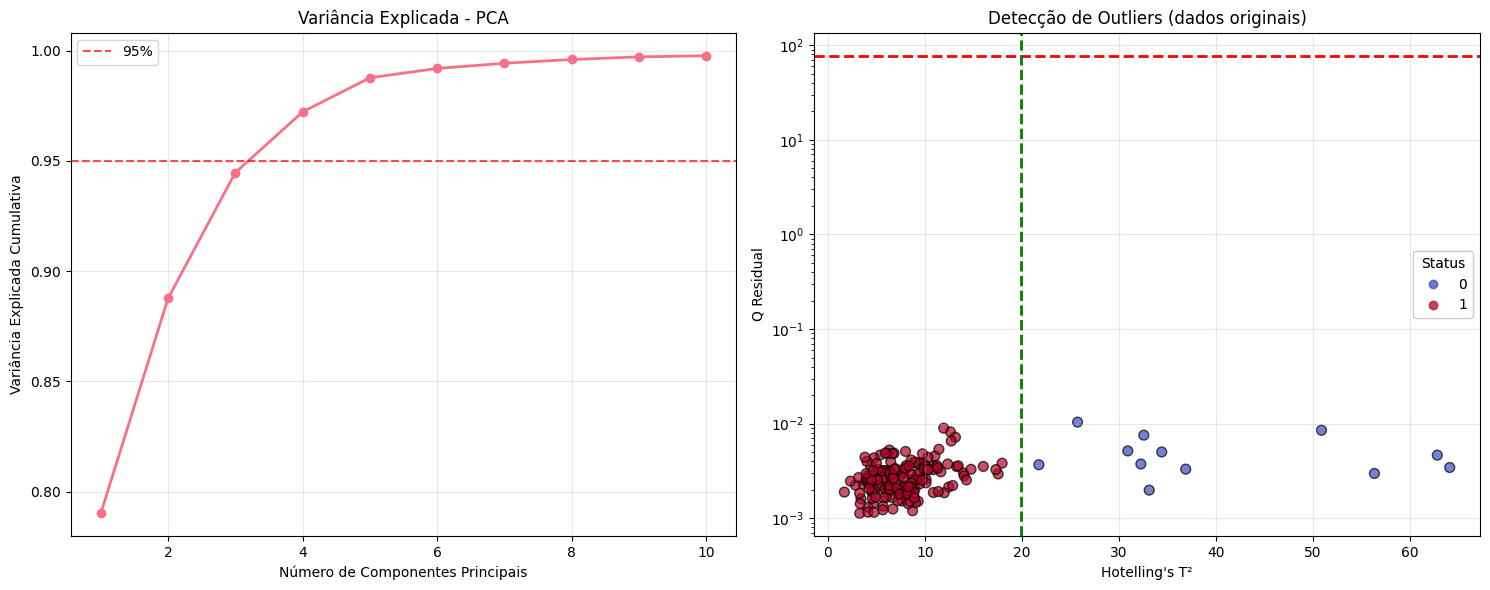

Gráfico de outliers exibido.



In [11]:
atributo_ref = atributos[0]
d = dados_pca[atributo_ref]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Variância explicada ---
cumulative_variance = np.cumsum(d['pca_model'].explained_variance_ratio_)
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Número de Componentes Principais')
axes[0].set_ylabel('Variância Explicada Cumulativa')
axes[0].set_title(f'Variância Explicada - PCA')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
axes[0].legend()

# --- T² vs Q (usando dados originais) ---
scatter = axes[1].scatter(d['T2'], d['Q'], c=d['keep_mask'], cmap='coolwarm',
                          edgecolors='k', alpha=0.7, s=50)
axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T² Limit: {d["T2_limit"]:.2f}')
axes[1].set_xlabel("Hotelling's T²")
axes[1].set_ylabel('Q Residual')
axes[1].set_title(f'Detecção de Outliers (dados originais)')
axes[1].legend()
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

# Legenda de status (0 = outlier, 1 = mantido)
legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
axes[1].add_artist(legend1)

plt.tight_layout()
plt.show()
print('Gráfico de outliers exibido.\n')

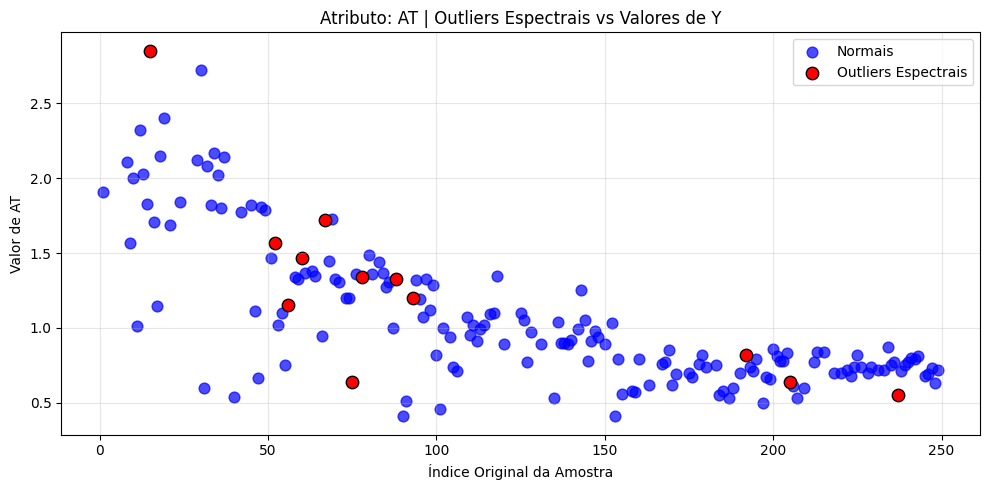

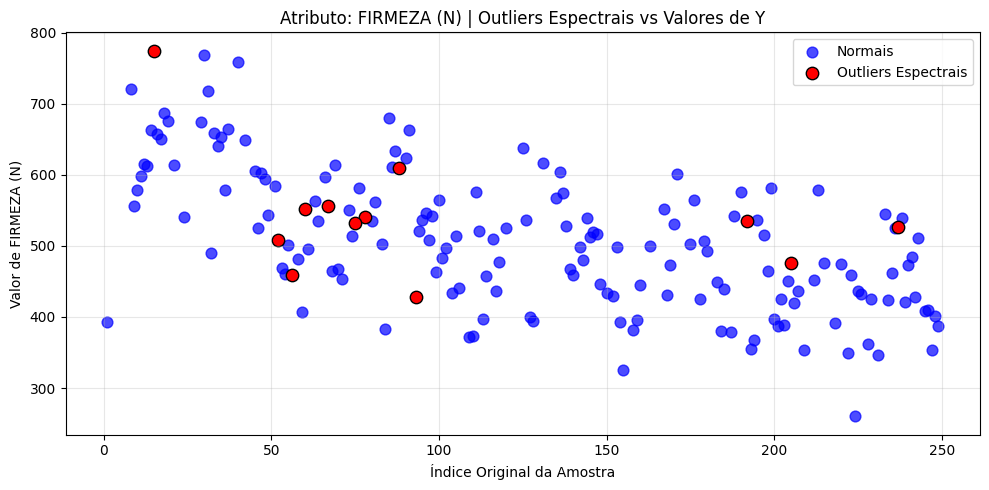

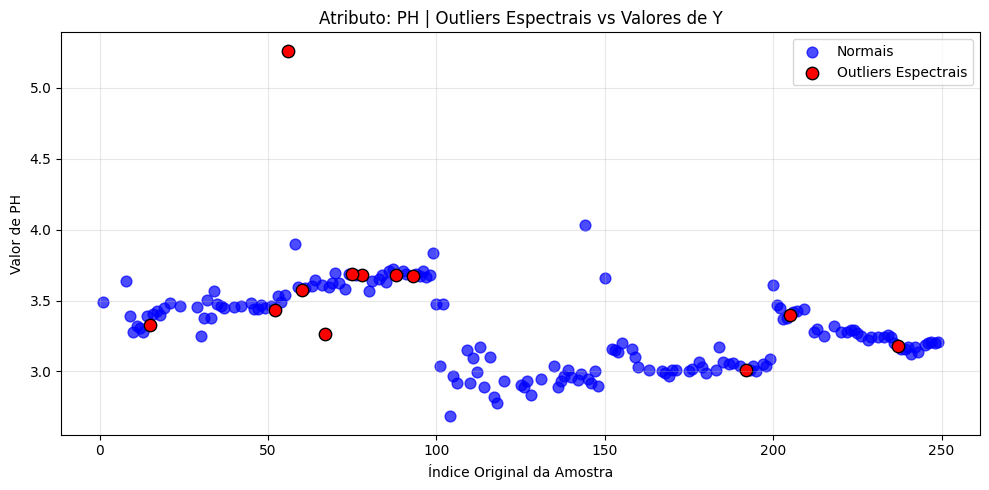

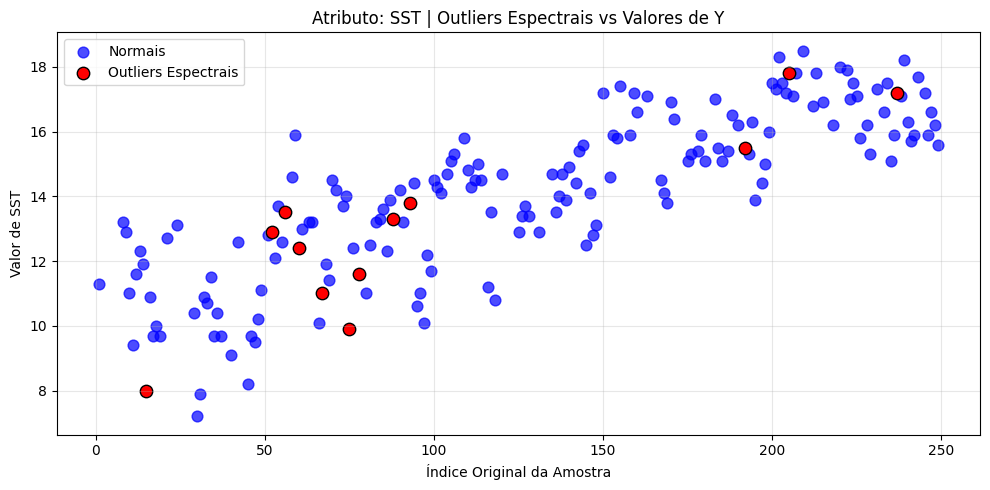

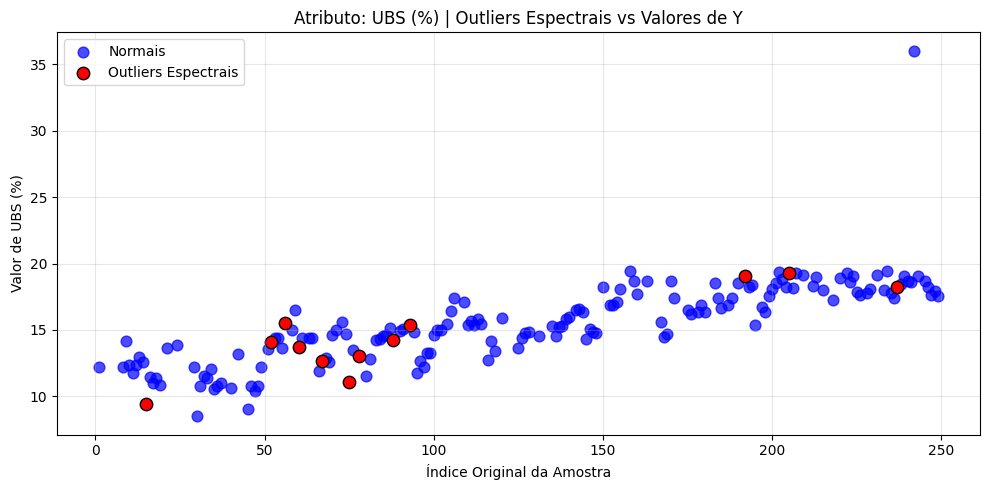

In [7]:
for atributo in atributos:
    d = dados_pca[atributo]

    y_cal = dados_divididos[atributo]['y_cal']
    indices_orig_cal = dados_divididos[atributo]['indices_orig_cal']

    keep_mask = d['keep_mask']
    outliers_mask = ~keep_mask

    plt.figure(figsize=(10, 5))

    # Amostras normais (não-outliers)
    plt.scatter(indices_orig_cal[keep_mask], y_cal[keep_mask],
                color='blue', label='Normais', alpha=0.7, s=60)

    # Outliers espectrais
    plt.scatter(indices_orig_cal[outliers_mask], y_cal[outliers_mask],
                color='red', label='Outliers Espectrais', edgecolor='k', s=80)

    plt.title(f'Atributo: {atributo} | Outliers Espectrais vs Valores de Y')
    plt.xlabel('Índice Original da Amostra')
    plt.ylabel(f'Valor de {atributo}')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Se Q ≈ 0 para todo mundo, significa que o PCA conseguiu representar os espectros muito bem → não há anomalias estruturais (o modelo reconstrói todo mundo).

Se T² é o que manda, então seus outliers são principalmente pontos extremos nos scores (ou seja, espectros que não são “estranhos” em forma, mas ficam longe do centro).

Isso é normal em dados espectrais bem comportados.

## 5. Remoção de Outliers dos Atributos (Boxplot + Seaborn)

Além dos outliers espectrais (em X), podemos ter outliers nos valores de referência (em y). Por exemplo, um valor de pH ou SST que é analiticamente improvável ou resultado de um erro de anotação.
- **Método (IQR):** O método do Intervalo Interquartil (IQR) é uma forma estatística robusta de identificar esses pontos.
    - `IQR = Q3 (percentil 75) - Q1 (percentil 25)`
    - Um valor é considerado outlier se estiver abaixo de `Q1 - 1.5 * IQR` ou acima de `Q3 + 1.5 * IQR`.
- **Visualização:** O `boxplot` é a ferramenta visual perfeita para essa análise, pois ele desenha os "bigodes" exatamente nesses limites de 1.5 * IQR, mostrando os outliers como pontos individuais.
- **Ação:** Novamente, a remoção é feita apenas no conjunto de calibração.

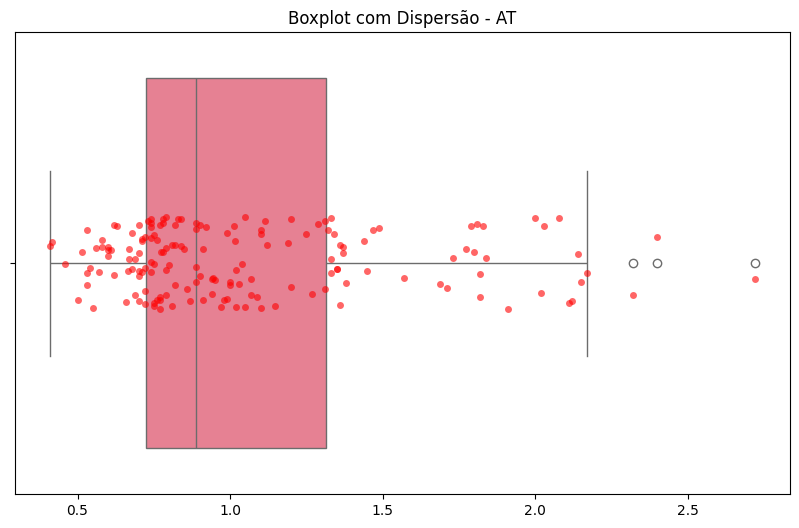

AT: 3 outliers de atributo removidos.
  Índices Originais Removidos: [12 30 19]
  Calibração final: 160 amostras
  Validação: 75 amostras



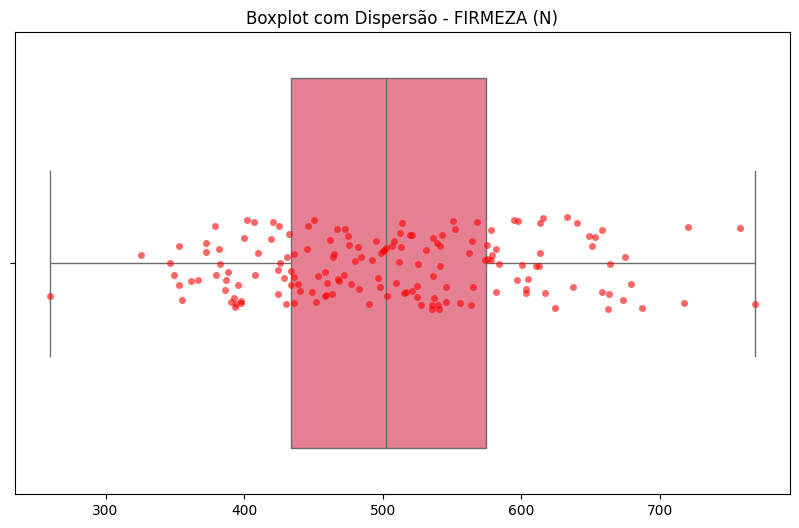

FIRMEZA (N): 0 outliers de atributo removidos.
  Calibração final: 163 amostras
  Validação: 75 amostras



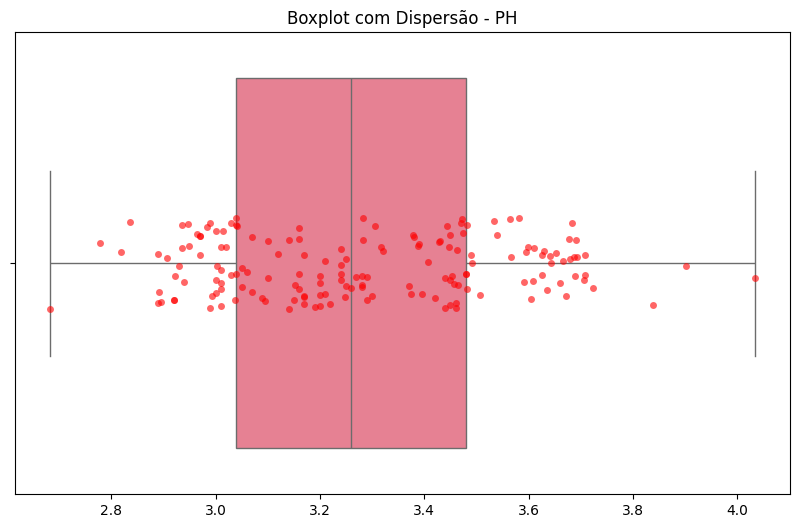

PH: 0 outliers de atributo removidos.
  Calibração final: 163 amostras
  Validação: 75 amostras



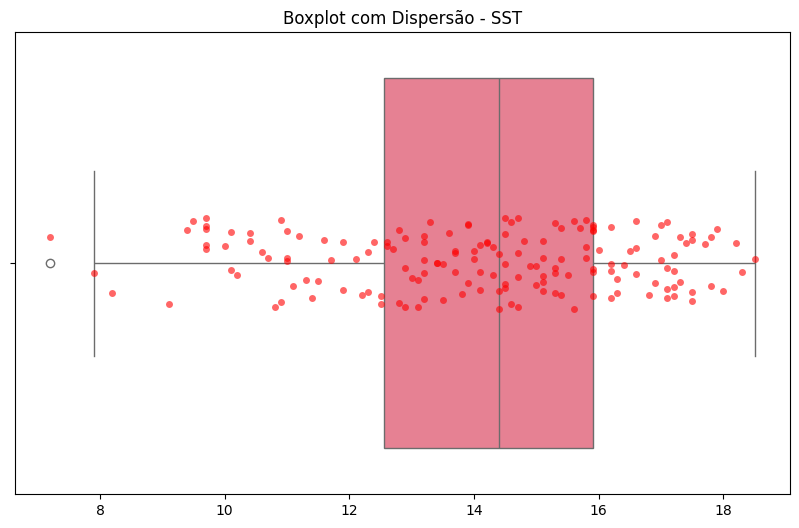

SST: 1 outliers de atributo removidos.
  Índices Originais Removidos: [30]
  Calibração final: 162 amostras
  Validação: 75 amostras



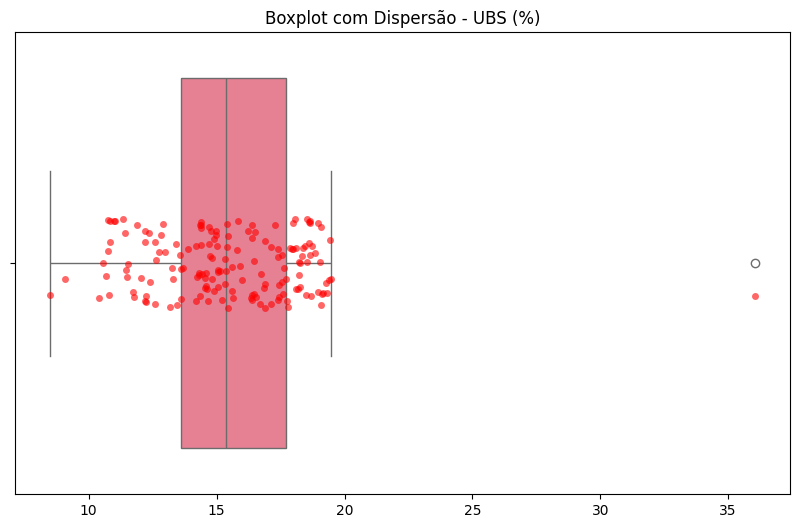

UBS (%): 1 outliers de atributo removidos.
  Índices Originais Removidos: [242]
  Calibração final: 162 amostras
  Validação: 75 amostras



In [20]:
# Remover outliers dos atributos usando boxplot e IQR
dados_final = {}

for atributo in atributos:
    # Pega os dados já limpos de outliers espectrais
    d = dados_pca[atributo]
    X_cal = d['X_cal']
    y_cal = d['y_cal']
    indices_orig_cal = d['indices_orig_cal']
    
    # Boxplot (seu código de plotagem original pode ser mantido aqui)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y_cal)
    sns.stripplot(x=y_cal, color='red', alpha=0.6)
    plt.title(f'Boxplot com Dispersão - {atributo}')
    plt.show()

    # Lógica de remoção de outliers
    Q1 = np.percentile(y_cal, 25)
    Q3 = np.percentile(y_cal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    keep_mask_attr = (y_cal >= lower_bound) & (y_cal <= upper_bound)
    
    # Identifica e informa os outliers removidos
    outliers_attr_indices = indices_orig_cal[~keep_mask_attr]
    print(f'{atributo}: {len(outliers_attr_indices)} outliers de atributo removidos.')
    if len(outliers_attr_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_attr_indices}')
    
    # Armazena os dados finais e limpos para modelagem
    dados_final[atributo] = {
        'X_cal': X_cal[keep_mask_attr],
        'y_cal': y_cal[keep_mask_attr],
        'X_val': dados_divididos[atributo]['X_val'], # Validação original
        'y_val': dados_divididos[atributo]['y_val']   # Validação original
    }
    
    print(f'  Calibração final: {dados_final[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Validação: {dados_final[atributo]["X_val"].shape[0]} amostras')
    print()

## 6. Filtros de Pré-processamento (Independentes e Dependentes de y)

Os dados espectrais brutos contêm diversas fontes de variação indesejada que podem mascarar a informação química relevante. Essas variações podem ser causadas por espalhamento de luz (efeitos físicos da amostra), mudanças na linha de base (drift do instrumento) e ruído. O pré-processing visa minimizar esses efeitos para que o modelo foque na correlação entre o espectro e o atributo de interesse.

Neste notebook, testamos uma ampla gama de filtros, divididos em duas categorias:

### Filtros Independentes de y

São aplicados apenas aos espectros (`X`) e não utilizam a informação da variável alvo (`y`).

-   **`Raw`**: Utiliza os dados espectrais brutos, sem nenhum tratamento. Serve como uma linha de base para comparar a eficácia dos outros filtros.
-   **`MSC` (Multiplicative Scatter Correction)**: Corrige o espalhamento de luz (aditivo e multiplicativo) causado por variações no tamanho de partícula e compactação da amostra. Ele ajusta cada espectro para se parecer mais com um espectro "ideal" (geralmente a média de todos os espectros).
-   **`SNV` (Standard Normal Variate)**: Alternativa ao MSC que também corrige o espalhamento de luz. A diferença é que o SNV padroniza cada espectro individualmente (subtrai a média e divide pelo desvio padrão daquele espectro), sem usar um espectro de referência.
-   **`SG_D1` e `SG_D2` (Savitzky-Golay Derivatives)**: Calcula a primeira ou a segunda derivada do espectro. Derivadas são excelentes para remover desvios de linha de base (efeitos aditivos) e para resolver picos espectrais sobrepostos, realçando a informação de bandas de absorção específicas.
-   **`Detrend`**: Remove tendências lineares ou polinomiais da linha de base do espectro. É muito eficaz para corrigir "inclinações" no espectro causadas por drift do instrumento.
-   **`Normalize`**: Realiza uma normalização Min-Max, escalonando a intensidade de cada espectro para um intervalo fixo (geralmente [0, 1]). Ajuda a corrigir variações de intensidade causadas por diferenças na distância da amostra ou na potência da fonte de luz.
-   **`EMSC` (Extended Multiplicative Signal Correction)**: Uma versão avançada do MSC. Além de corrigir os efeitos de espalhamento, o EMSC pode incluir termos polinomiais para modelar e remover efeitos de linha de base mais complexos e não-lineares.
-   **`Continuum Removal`**: Técnica que normaliza os espectros para que as bandas de absorção possam ser comparadas em termos de sua profundidade, e não de sua intensidade absoluta. Ele ajusta um "envelope" (casco convexo) sobre o espectro e divide o espectro original por este envelope, realçando as características de absorção.
-   **`Wavelet_Denoising`**: Utiliza a Transformada Wavelet para decompor o espectro em diferentes níveis de frequência. A técnica permite remover o ruído (geralmente presente em altas frequências) de forma muito eficaz, preservando as principais características do sinal espectral.

### Filtros Dependentes de y e Combinações

Estes filtros utilizam a variável alvo (`y`) para otimizar a remoção de variação não correlacionada em `X`, ou são combinações sequenciais de múltiplos filtros para um tratamento mais completo.

-   **`OSC_1` e `OSC_2` (Orthogonal Signal Correction)**: Filtro que remove componentes (1 ou 2, neste caso) dos espectros `X` que são ortogonais (não correlacionados) à variável alvo `y`. O objetivo é limpar `X` da variação que não ajuda na predição, potencialmente melhorando o modelo subsequente. Esta técnica é frequentemente referida como um pré-processamento **OPLS** (Orthogonal Projections to Latent Structures).
-   **`MSC_SG_OSC`**: Uma **cadeia de pré-processamentos** aplicada na seguinte ordem:
    1.  `MSC` para corrigir o espalhamento.
    2.  `Savitzky-Golay (1ª derivada)` para corrigir a linha de base.
    3.  `OSC (1 componente)` para remover variação não correlacionada com `y`.
-   **`OPLS1_SNV_SG_D1` e `OPLS2_SNV_SG_D1`**: Outra cadeia de processamento:
    1.  `SNV` para correção de espalhamento.
    2.  `Savitzky-Golay (1ª derivada)`.
    3.  `OPLS/OSC` para remover 1 ou 2 componentes ortogonais a `y`.
-   **`SNV_Detrend_SG_D1`**: Uma combinação de filtros independentes de `y`, mas que, por sua complexidade, é testada junto às outras cadeias:
    1.  `SNV`.
    2.  `Detrend` para remoção de tendência.
    3.  `Savitzky-Golay (1ª derivada)`.

In [8]:
# Implementação dos filtros de pré-processamento
# Filtros independentes de y
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normalização Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro médio como referência
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ≈ a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpolação linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposição Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. Cálculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplicação do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstrução do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover variação ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicionário de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicionário de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


## 7. Avaliação dos Filtros e Seleção dos Melhores

Esta seção automatiza o processo de treinamento, otimização e avaliação do modelo MLP Regressor (Rede Neural). O fluxo é projetado para testar rigorosamente todas as combinações de pré-processamento.

-   **Fluxo de Trabalho Automatizado:**
    1.  **Iteração por Atributo e Filtro:** O código itera sobre cada atributo e, para cada um, aplica todos os 16 filtros de pré-processamento definidos anteriormente.
    2.  **Padronização dos Dados:** É **essencial** escalar os dados (`StandardScaler`) antes de alimentar uma rede neural. Isso garante que o modelo convirja de forma mais rápida e estável.
    3.  **Otimização de Hiperparâmetros (`GridSearchCV`):** Para cada filtro, uma busca em grade otimiza os principais hiperparâmetros do MLPR, como a arquitetura das camadas ocultas (`hidden_layer_sizes`), a função de ativação e o método de otimização (`solver`).
    4.  **Avaliação e Salvamento:** O melhor modelo de cada combinação é avaliado no conjunto de validação. As métricas de desempenho, os melhores parâmetros e os gráficos de predição vs. real são salvos automaticamente para análise posterior.

In [9]:
# --- Função para o Gráfico de CALIBRAÇÃO (Ref vs Predito vs CV) ---
def save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, filtro, modelo, file_path):
    """
    Gera e salva um gráfico comparando predições de treino e de validação cruzada
    no conjunto de calibração.
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Métricas para Predição no Treino Completo
        slope_pred, offset_pred = np.polyfit(y_cal, y_pred_cal, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
        r2_pred = r2_score(y_cal, y_pred_cal)

        # Métricas para Predição da Validação Cruzada
        slope_cv, offset_cv = np.polyfit(y_cal, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_cal, y_pred_cv))
        r2_cv = r2_score(y_cal, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_cal, y_pred_cal, color='blue', marker='o', alpha=0.6, label=f'Predição no Treino (R²={r2_pred:.3f})')
        plt.scatter(y_cal, y_pred_cv, color='red', marker='x', alpha=0.7, label=f'Predição CV (R²={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_cal), min(y_pred_cal), min(y_pred_cv))
        max_val = max(max(y_cal), max(y_pred_cal), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais (Calibração)")
        plt.ylabel("Valores Preditos")
        plt.title(f'Desempenho na Calibração: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com métricas
        stats_text = (
            f'Treino - RMSE: {rmse_pred:.3f}, Slope: {slope_pred:.3f}, Offset: {offset_pred:.3f}\n'
            f'CV     - RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        )
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de calibração para {modelo} com {filtro}: {e}")
        plt.close()


# --- Função para o Gráfico de VALIDAÇÃO (Predito vs Real) ---
def save_validation_plot(y_val, y_pred_val, atributo, filtro, modelo, file_path):
    """
    Gera e salva o gráfico de predições no conjunto de validação (teste).
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # Métricas
        r2 = r2_score(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        slope, offset = np.polyfit(y_val, y_pred_val, 1)

        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolors='k', label='Dados de Validação')
        
        # Linha ideal 1:1
        min_val = min(min(y_val), min(y_pred_val))
        max_val = max(max(y_val), max(y_pred_val))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal (1:1)')

        plt.xlabel('Valores Reais (Validação)')
        plt.ylabel('Valores Preditos')
        plt.title(f'Desempenho na Validação: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        
        stats_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nSlope = {slope:.4f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
        
        plt.legend()
        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de validação para {modelo} com {filtro}: {e}")
        plt.close()

In [ ]:
# 1. Definir o modelo MLPR e seu grid de parâmetros
# (Grid menor para um teste mais rápido, pode ser expandido)
param_grid_mlpr = {
    'hidden_layer_sizes': [
        (120, 10,1),
        (5,), (8,), (12,), (30,),
        (10,), (15,), (20,), (25,), (32,),
        (20, 10), (32, 16), (64, 32), (50, 20),
        (20, 15, 10),
        (16, 8), (20, 20),
        ],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'early_stopping': [True],
    'max_iter': [1000]
}

# Combina todos os filtros
todos_filtros = {**filtros_independentes, **filtros_dependentes}

# Lista para armazenar todos os resultados
lista_resultados_finais_mlpr = []
os.makedirs('graficos_mlpr', exist_ok=True) # Cria pasta para salvar gráficos

# 2. Loop principal de modelagem
for atributo in atributos:
    print(f'\n{"="*30}')
    print(f'INICIANDO MODELAGEM MLPR PARA: {atributo}')
    print(f'{"="*30}')
    
    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    # É crucial escalar os dados para o MLPR
    scaler = StandardScaler()
    X_cal_scaled = scaler.fit_transform(X_cal)
    X_val_scaled = scaler.transform(X_val)

    for nome_filtro, funcao_filtro in todos_filtros.items():
        start_time = time.time()
        print(f'  Testando filtro: {nome_filtro}...', end='')

        # Aplicar filtro aos dados já escalados
        if nome_filtro in filtros_independentes:
            X_cal_f = funcao_filtro(X_cal_scaled)
            X_val_f = funcao_filtro(X_val_scaled)
        else: # Filtro dependente de Y
            osc_model = OrthogonalCorrection(n_components=1)
            X_cal_f = osc_model.fit_transform(X_cal_scaled, y_cal)
            X_val_f = osc_model.transform(X_val_scaled)
        
        # GridSearchCV
        mlpr = MLPRegressor(random_state=42)
        grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1, verbose=0)
        grid.fit(X_cal_f, y_cal)
        
        melhor_modelo = grid.best_estimator_
        
        # Avaliação final no conjunto de validação
        y_pred = melhor_modelo.predict(X_val_f)
        r2_val = r2_score(y_val, y_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
        
        end_time = time.time()
        print(f' R² Val: {r2_val:.4f} | Concluído em {end_time - start_time:.2f}s')
        
        # Salvar resultados
        lista_resultados_finais_mlpr.append({
            'Atributo': atributo,
            'Modelo': 'MLPR',
            'Filtro': nome_filtro,
            'CV_R2': grid.best_score_,
            'Val_R2': r2_val,
            'Val_RMSE': rmse_val,
            'Melhores_Params': str(grid.best_params_),
            'Tempo_s': end_time - start_time
        })
        
        # --- Lógica de plotagem nova e aprimorada para MLPR ---

        # 1. Gera as predições necessárias para os gráficos
        y_pred_cal = melhor_modelo.predict(X_cal_f)
        # Para o CV do MLPR, usamos um modelo base para agilizar
        base_mlpr = MLPRegressor(random_state=42, max_iter=1000) 
        y_pred_cv = cross_val_predict(base_mlpr, X_cal_f, y_cal, cv=5)

        # 2. Chama a função para o gráfico de CALIBRAÇÃO
        path_cal = f'graficos_mlpr/calibracao/{atributo}_MLPR_{nome_filtro}.png'
        save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, nome_filtro, 'MLPR', path_cal)

        # 3. Chama a função para o gráfico de VALIDAÇÃO
        #    (y_pred já foi calculado antes como a predição em y_val)
        path_val = f'graficos_mlpr/validacao/{atributo}_MLPR_{nome_filtro}.png'
        save_validation_plot(y_val, y_pred, atributo, nome_filtro, 'MLPR', path_val)

print('\n\n✅ Modelagem MLPR exaustiva concluída!')

# 3. Criar DataFrame e exportar para Excel
df_mlpr = pd.DataFrame(lista_resultados_finais_mlpr)
df_mlpr_ordenado = df_mlpr.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_mlpr_ordenado.to_excel('resultados_modelagem_mlpr.xlsx', index=False)

print('✅ Resultados salvos em "resultados_modelagem_mlpr.xlsx"')

# 4. Exibir melhores resultados
print("\n--- Melhores Resultados por Atributo (MLPR) ---")
melhores_mlpr = df_mlpr_ordenado.groupby('Atributo').first().reset_index()
colunas_numericas_para_arredondar = ['Val_R2', 'Val_RMSE']
melhores_mlpr[colunas_numericas_para_arredondar] = melhores_mlpr[colunas_numericas_para_arredondar].round(4)

colunas_para_exibir = ['Atributo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params']
print(melhores_mlpr[colunas_para_exibir])


INICIANDO MODELAGEM MLPR PARA: AT
  Testando filtro: Raw... R² Val: 0.4361 | Concluído em 200.59s
  Testando filtro: MSC... R² Val: -0.0767 | Concluído em 200.40s
  Testando filtro: SNV... R² Val: 0.4099 | Concluído em 239.67s
  Testando filtro: SG_D1... R² Val: 0.4502 | Concluído em 258.61s
  Testando filtro: SG_D2... R² Val: 0.2296 | Concluído em 251.02s
  Testando filtro: Detrend... R² Val: 0.4524 | Concluído em 225.07s
  Testando filtro: Normalize... R² Val: 0.2797 | Concluído em 169.83s
  Testando filtro: EMSC... R² Val: -0.0652 | Concluído em 90.68s
  Testando filtro: Continuum_Removal... R² Val: -0.0477 | Concluído em 97.72s
  Testando filtro: Wavelet_Denoising... R² Val: 0.4248 | Concluído em 198.60s
  Testando filtro: OSC_1... R² Val: 0.4201 | Concluído em 240.00s
  Testando filtro: OSC_2... R² Val: 0.4201 | Concluído em 234.80s
  Testando filtro: MSC_SG_OSC... R² Val: 0.4201 | Concluído em 238.87s
  Testando filtro: OPLS1_SNV_SG_D1... R² Val: 0.4201 | Concluído em 238.58s
  

## 8. Exploração Aprofundada dos Melhores Filtros com Ajuste de Parâmetros

Nesta seção, realizamos uma nova rodada de modelagem utilizando apenas os melhores filtros identificados na análise anterior. Para filtros que aceitam parâmetros ajustáveis (como Savitzky-Golay, Wavelet Denoising e OSC), testamos múltiplas combinações desses parâmetros a fim de maximizar a performance do modelo. Usamos novamente uma abordagem com GridSearch para o MLPRegressor e reportamos os melhores parâmetros de cada combinação. Além disso, geramos gráficos de calibração e validação para facilitar a interpretação visual dos resultados.

In [11]:
print("="*50)
print("🔬 INICIANDO OTIMIZAÇÃO FINA DOS MELHORES FILTROS 🔬")
print("="*50)

# 1. Selecionar os melhores filtros identificados na análise anterior
melhores_filtros_por_atributo = {
    'AT': ['Detrend', 'Normalize', 'Raw', 'Wavelet_Denoising', 'OSC_1', 'MSC', 'EMSC', 'OSC_2'],
    'FIRMEZA (N)': ['EMSC', 'MSC', 'Wavelet_Denoising', 'Raw', 'SNV', 'Detrend', 'Normalize', 'OSC_1'],
    'PH': ['OSC_1', 'Detrend', 'Raw', 'Wavelet_Denoising', 'OSC_2', 'SG_D1', 'SNV', 'SG_D1'],
    'SST': ['SNV_Detrend_SG_D1', 'OPLS2_SNV_SG_D1', 'Detrend', 'SNV', 'OSC_1', 'OPLS1_SNV_SG_D1'],
    'UBS (%)': ['OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1', 'OPLS1_SNV_SG_D1', 'MSC_SG_OSC', 'SNV']
}

# 2. Definir os grids de parâmetros para os filtros que aceitam otimização
sg_params_to_test = {
    'window_size': [5, 11, 15, 21, 27, 35, 41],
        'poly_order': [2, 3, 4],
        'deriv_order': [1, 2]
}

osc_params_to_test = {
    'n_components': [1, 2, 3]
}

wavelet_params_to_test = {
    'wavelet': ['db1', 'db2', 'db3', 'db4', 'db5'],
    'level': [1,2, 3, 4, 5]
}

# 3. Definir o grid do modelo MLPR (o mesmo de antes)
param_grid_mlpr = {
    'hidden_layer_sizes': [
        (120, 10,1),
        (5,), (8,), (12,), (30,),
        (10,), (15,), (20,), (25,), (32,),
        (20, 10), (32, 16), (64, 32), (50, 20),
        (20, 15, 10),
        (16, 8), (20, 20),
        
        ],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'early_stopping': [True],
    'max_iter': [1000]
}

# Lista para armazenar os novos resultados
lista_resultados_otimizados_mlpr = []

# 4. Loop principal de modelagem e otimização
for atributo, lista_melhores_filtros in melhores_filtros_por_atributo.items():
    print(f'\n{"="*30}')
    print(f'OTIMIZANDO FILTROS PARA: {atributo}')
    print(f'{"="*30}')
    
    # Carregar dados (assumindo que 'dados_final' está disponível)
    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    # Escalar os dados brutos uma única vez
    scaler = StandardScaler()
    X_cal_scaled = scaler.fit_transform(X_cal)
    X_val_scaled = scaler.transform(X_val)

    for nome_filtro in lista_melhores_filtros:
        print(f'\n--- Otimizando filtro: {nome_filtro} ---')
        start_time_total = time.time()
        
        # Variáveis para guardar o melhor resultado para ESTE filtro
        melhor_resultado_do_filtro = {
            'Val_R2': -np.inf, 
            'Val_RMSE': np.inf,
            'Melhores_Params_Filtro': 'N/A',
            'Melhores_Params_Modelo': None,
            'Tempo_s': 0
        }
        
        # Lógica para aplicar os grids de parâmetros dos filtros
        
        # CASO 1: Filtros que usam Savitzky-Golay (SG) e OSC/OPLS
        if ('SG' in nome_filtro) and ('OSC' in nome_filtro or 'OPLS' in nome_filtro):
            print(f'  (Grid Search em SG e OSC/OPLS ativado)')
            sg_grid = ParameterGrid(sg_params_to_test)
            
            for n_comp in osc_params_to_test['n_components']:
                for sg_p in sg_grid:
                    # Evitar combinação inválida
                    if sg_p['poly_order'] >= sg_p['window_size']:
                        continue
                        
                    params_filtro_str = f"OSC_n_comp={n_comp}, SG_params={sg_p}"
                    print(f'    Testando: {params_filtro_str}...', end='')
                    start_time_iter = time.time()
                    
                    try:
                        # Aplicar pré-filtros (SNV, etc.)
                        X_cal_pre, X_val_pre = snv(X_cal_scaled), snv(X_val_scaled)
                        # Aplicar SG
                        X_cal_sg = savitzky_golay(X_cal_pre, **sg_p)
                        X_val_sg = savitzky_golay(X_val_pre, **sg_p)
                        # Aplicar OSC/OPLS
                        osc_model = OrthogonalCorrection(n_components=n_comp)
                        X_cal_f = osc_model.fit_transform(X_cal_sg, y_cal)
                        X_val_f = osc_model.transform(X_val_sg)
                    except Exception as e:
                        print(f" Erro ao aplicar filtro: {e}")
                        continue

                    # Roda o GridSearchCV para o MLPR
                    mlpr = MLPRegressor(random_state=42)
                    grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                    grid.fit(X_cal_f, y_cal)
                    
                    # Avaliação
                    y_pred = grid.best_estimator_.predict(X_val_f)
                    r2_val = r2_score(y_val, y_pred)
                    
                    print(f' R² Val: {r2_val:.4f}')
                    
                    # Atualiza se o resultado for melhor
                    if r2_val > melhor_resultado_do_filtro['Val_R2']:
                        melhor_resultado_do_filtro['Val_R2'] = r2_val
                        melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                        melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                        melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)
            
        # CASO 2: Filtros que usam SÓ Savitzky-Golay (SG)
        elif 'SG' in nome_filtro:
            print(f'  (Grid Search em SG ativado)')
            sg_grid = ParameterGrid(sg_params_to_test)
            for sg_p in sg_grid:
                 if sg_p['poly_order'] >= sg_p['window_size']:
                        continue
                
                 params_filtro_str = f"SG_params={sg_p}"
                 print(f'    Testando: {params_filtro_str}...', end='')

                 try:
                    # Aplicar pré-filtros
                    X_cal_pre, X_val_pre = snv(X_cal_scaled), snv(X_val_scaled)
                    X_cal_pre, X_val_pre = detrend_filter(X_cal_pre), detrend_filter(X_val_pre)
                    # Aplicar SG
                    X_cal_f = savitzky_golay(X_cal_pre, **sg_p)
                    X_val_f = savitzky_golay(X_val_pre, **sg_p)
                 except Exception as e:
                    print(f" Erro ao aplicar filtro: {e}")
                    continue

                 mlpr = MLPRegressor(random_state=42)
                 grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                 grid.fit(X_cal_f, y_cal)
                 y_pred = grid.best_estimator_.predict(X_val_f)
                 r2_val = r2_score(y_val, y_pred)
                 print(f' R² Val: {r2_val:.4f}')
                 if r2_val > melhor_resultado_do_filtro['Val_R2']:
                    melhor_resultado_do_filtro['Val_R2'] = r2_val
                    melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                    melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                    melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # CASO 3: Filtros que usam SÓ OSC/OPLS (e não SG)
        elif 'OSC' in nome_filtro:
            print(f'  (Grid Search em OSC ativado)')
            for n_comp in osc_params_to_test['n_components']:
                params_filtro_str = f"OSC_n_comp={n_comp}"
                print(f'    Testando: {params_filtro_str}...', end='')
                
                osc_model = OrthogonalCorrection(n_components=n_comp)
                X_cal_f = osc_model.fit_transform(X_cal_scaled, y_cal)
                X_val_f = osc_model.transform(X_val_scaled)
                
                mlpr = MLPRegressor(random_state=42)
                grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                grid.fit(X_cal_f, y_cal)
                y_pred = grid.best_estimator_.predict(X_val_f)
                r2_val = r2_score(y_val, y_pred)
                print(f' R² Val: {r2_val:.4f}')
                if r2_val > melhor_resultado_do_filtro['Val_R2']:
                    melhor_resultado_do_filtro['Val_R2'] = r2_val
                    melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                    melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                    melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # CASO 4: Filtros não parametrizáveis (rodam apenas uma vez)
        else:
            print(f'  (Filtro não parametrizável, rodando com configuração padrão)')
            # Aplica o filtro (aqui usamos um dicionário para chamar a função certa)
            filtros_nao_parametrizaveis = {
                'Detrend': detrend_filter,
                'Normalize': normalize,
                'EMSC': emsc,
                'MSC': msc,
                'SNV': snv # Adicionado para completude
            }
            funcao_filtro = filtros_nao_parametrizaveis.get(nome_filtro, lambda x: x)
            X_cal_f = funcao_filtro(X_cal_scaled)
            X_val_f = funcao_filtro(X_val_scaled)
            
            mlpr = MLPRegressor(random_state=42)
            grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
            grid.fit(X_cal_f, y_cal)
            y_pred = grid.best_estimator_.predict(X_val_f)
            
            melhor_resultado_do_filtro['Val_R2'] = r2_score(y_val, y_pred)
            melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
            melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # Armazenar o melhor resultado encontrado para o filtro atual
        end_time_total = time.time()
        lista_resultados_otimizados_mlpr.append({
            'Atributo': atributo,
            'Modelo': 'MLPR',
            'Filtro': nome_filtro,
            'Val_R2': melhor_resultado_do_filtro['Val_R2'],
            'Val_RMSE': melhor_resultado_do_filtro['Val_RMSE'],
            'Melhores_Params_Filtro': melhor_resultado_do_filtro['Melhores_Params_Filtro'],
            'Melhores_Params_Modelo': melhor_resultado_do_filtro['Melhores_Params_Modelo'],
            'Tempo_s': end_time_total - start_time_total
        })
        
        print(f'--- Melhor resultado para {nome_filtro}: R² = {melhor_resultado_do_filtro["Val_R2"]:.4f} ---')
        print(f'    Parâmetros do Filtro: {melhor_resultado_do_filtro["Melhores_Params_Filtro"]}')
        print(f'    Parâmetros do Modelo: {melhor_resultado_do_filtro["Melhores_Params_Modelo"]}')
        
print('\n\n✅ Otimização Fina concluída!')

# 5. Criar DataFrame e exportar os resultados otimizados
df_mlpr_otimizado = pd.DataFrame(lista_resultados_otimizados_mlpr)
df_mlpr_otimizado_ordenado = df_mlpr_otimizado.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_mlpr_otimizado_ordenado.to_excel('resultados_otimizacao_filtros_mlpr.xlsx', index=False)

print('✅ Resultados da otimização salvos em "resultados_otimizacao_filtros_mlpr.xlsx"')

# 6. Exibir melhores resultados da otimização
print("\n--- Melhores Resultados por Atributo (Após Otimização de Filtros) ---")
melhores_otimizados_mlpr = df_mlpr_otimizado_ordenado.groupby('Atributo').first().reset_index()
print(melhores_otimizados_mlpr[['Atributo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params_Filtro']].round(4))

🔬 INICIANDO OTIMIZAÇÃO FINA DOS MELHORES FILTROS 🔬

OTIMIZANDO FILTROS PARA: AT

--- Otimizando filtro: Detrend ---
  (Filtro não parametrizável, rodando com configuração padrão)
--- Melhor resultado para Detrend: R² = 0.4524 ---
    Parâmetros do Filtro: N/A
    Parâmetros do Modelo: {'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (25,), 'max_iter': 1000, 'solver': 'adam'}

--- Otimizando filtro: Normalize ---
  (Filtro não parametrizável, rodando com configuração padrão)
--- Melhor resultado para Normalize: R² = 0.2797 ---
    Parâmetros do Filtro: N/A
    Parâmetros do Modelo: {'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (20, 15, 10), 'max_iter': 1000, 'solver': 'adam'}

--- Otimizando filtro: Raw ---
  (Filtro não parametrizável, rodando com configuração padrão)
--- Melhor resultado para Raw: R² = 0.4361 ---
    Parâmetros do Filtro: N/A
    Parâmetros do Modelo: {'activation': 'logistic', 'alpha': 0.